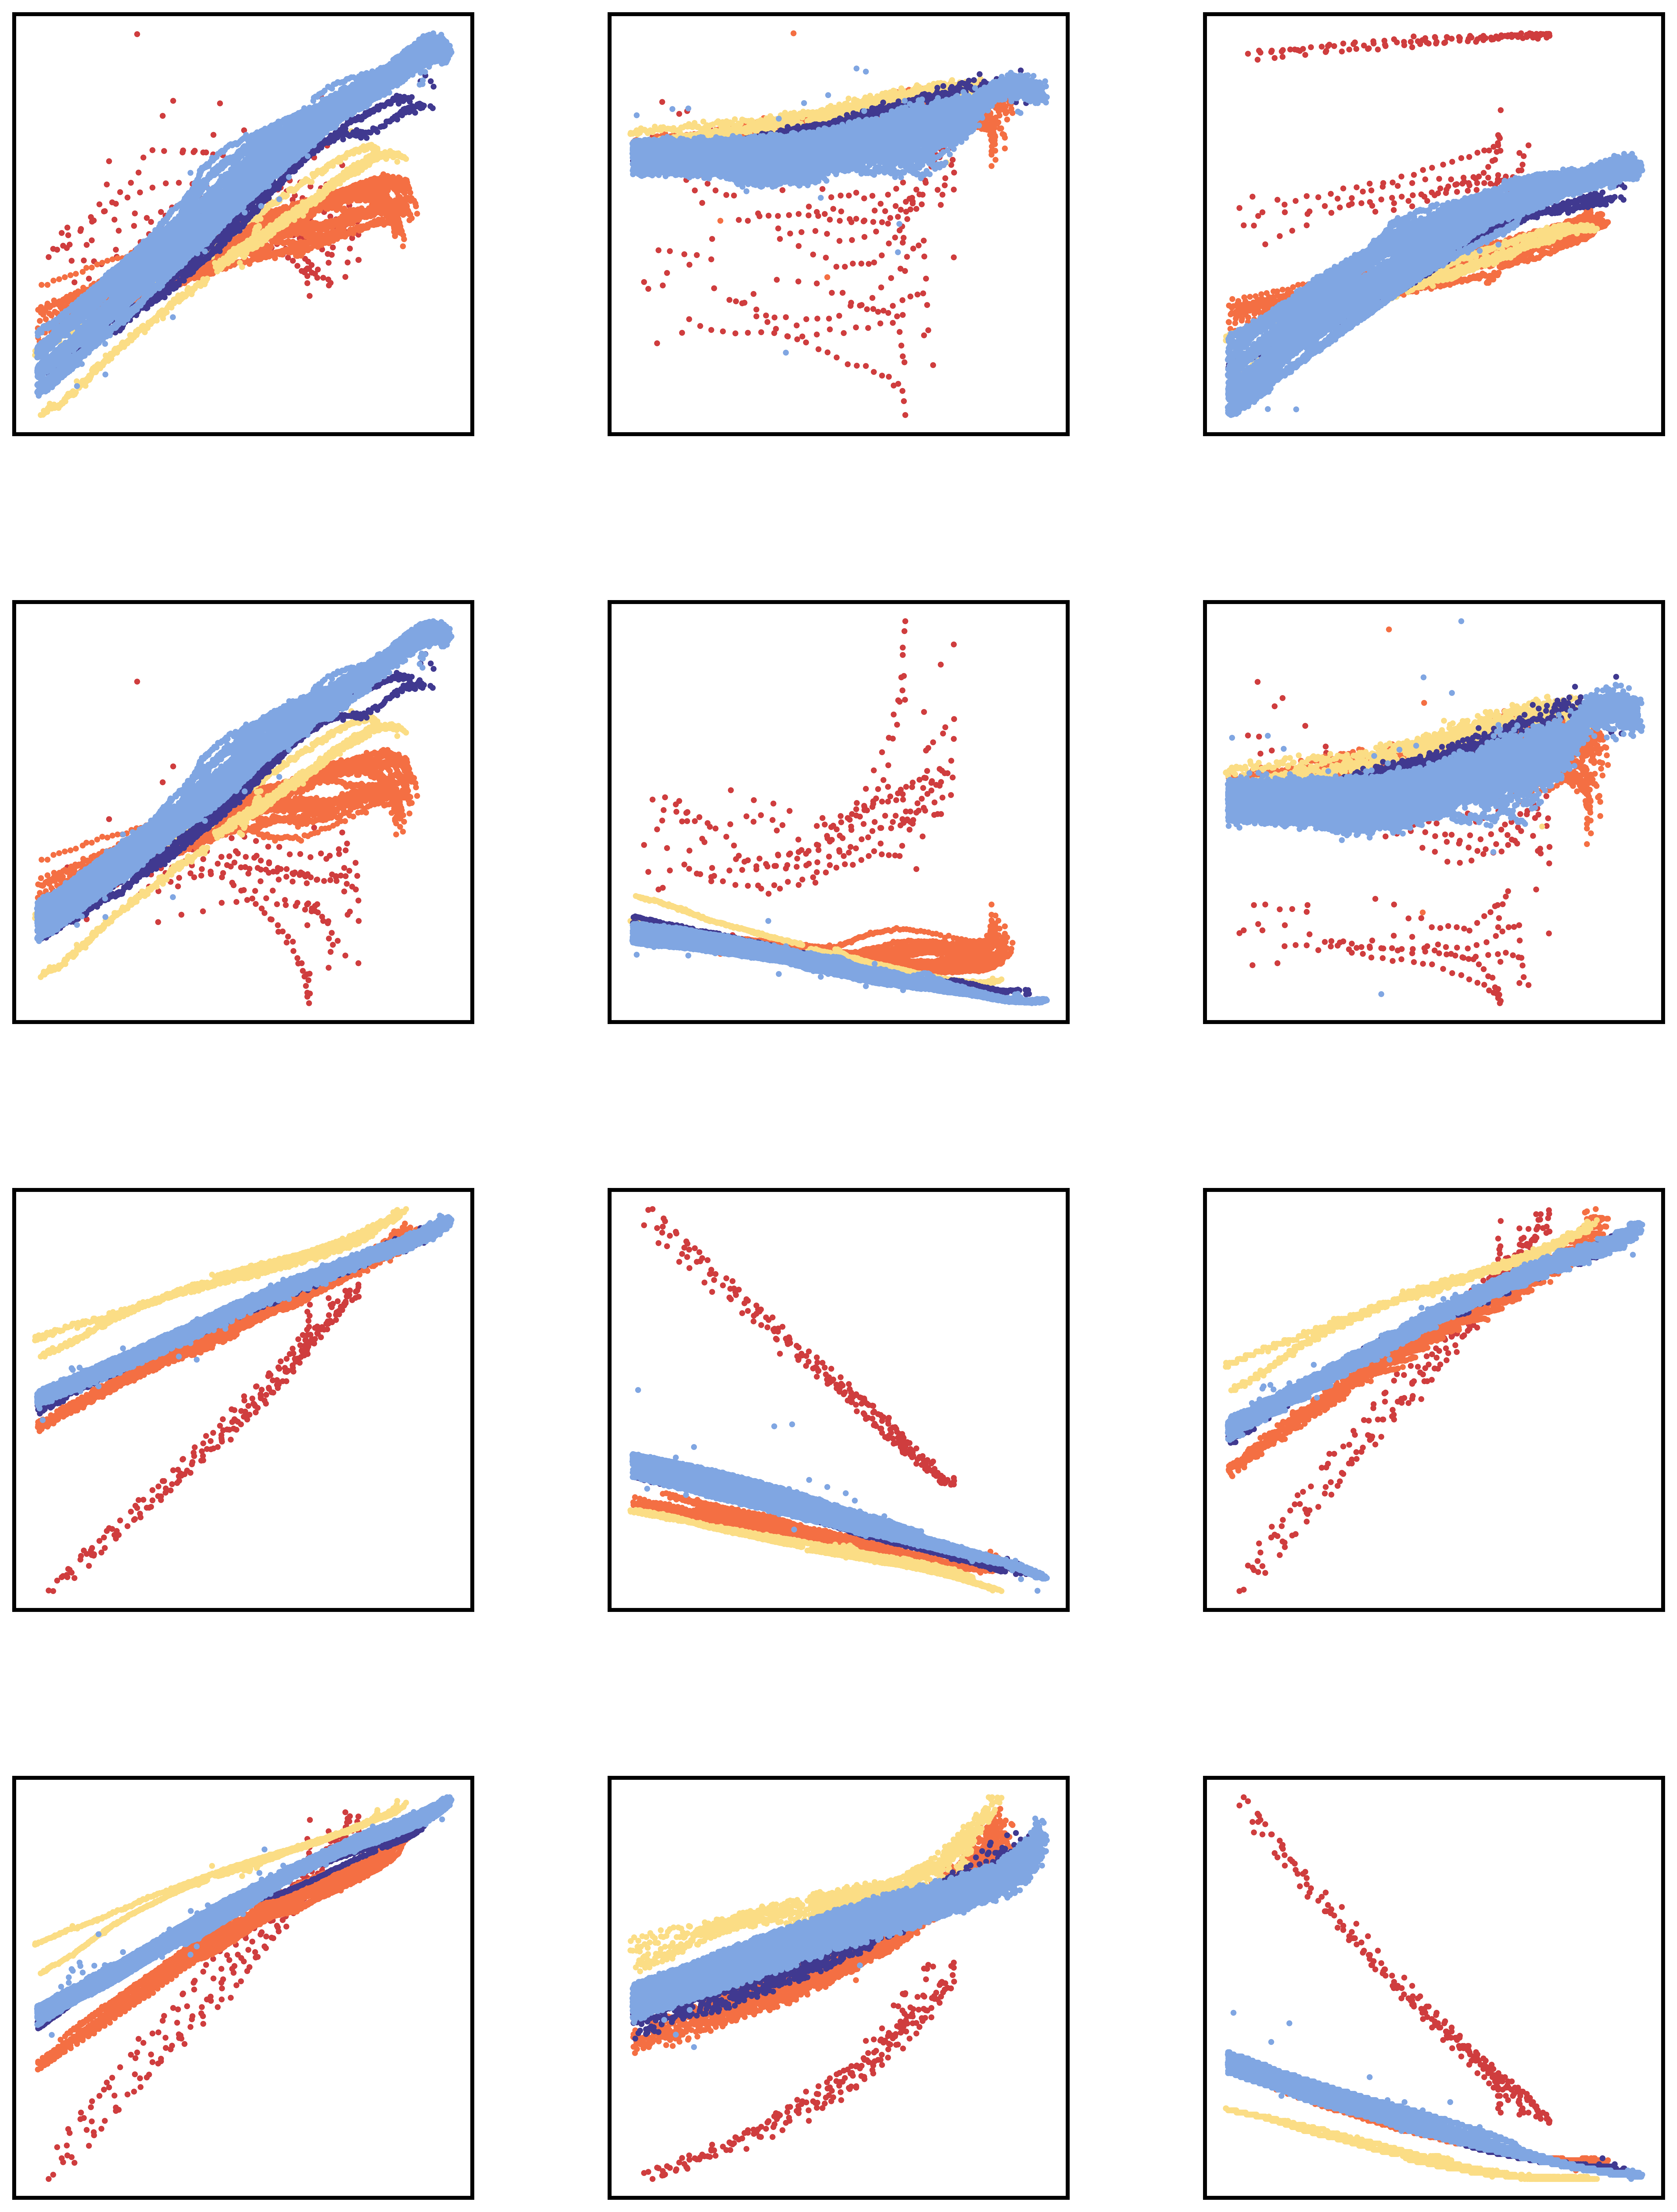

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
import ast
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

input_folder = 'dataset/UL-NCA/'

file_types = {
    'CY25-1_1': ('CY25-1_1-#1.csv', 'CY25-1_1-#9.csv'),
    'CY25-05_1': ('CY25-05_1-#1.csv', 'CY25-05_1-#19.csv'),
    'CY25-025_1': ('CY25-025_1-#1.csv', 'CY25-025_1-#3.csv'),
    'CY35-05_1': ('CY35-05_1-#1.csv', 'CY35-05_1-#3.csv'),
    'CY45-05_1': ('CY45-05_1-#1.csv', 'CY45-05_1-#28.csv')
}

def extract_features(data):
    features_list = []
    discharge_capacity_list = []
    for i in range(len(data)):
        relaxation_voltage = data.iloc[i]['Relaxation_Voltage']
        if isinstance(relaxation_voltage, str):
            relaxation_voltage = ast.literal_eval(relaxation_voltage)

        capacity_increment = data.iloc[i]['Capacity_Increment']
        if isinstance(capacity_increment, str):
            capacity_increment = ast.literal_eval(capacity_increment)

        capacity_increment = np.array(capacity_increment)
        voltage_range = np.linspace(3.6, 4.15, len(capacity_increment))
        interpolated_voltage_range = np.linspace(3.6, 4.15, 1000)
        interpolated_capacity_increment = np.interp(
            interpolated_voltage_range,
            voltage_range,
            capacity_increment
        )

        idx_005 = np.argmin(np.abs(interpolated_voltage_range - 3.65))
        capacity_at_005 = interpolated_capacity_increment[idx_005]
        target_capacity = capacity_at_005 + 200
        target_idx = np.argmax(interpolated_capacity_increment >= target_capacity)
        voltage_at_target = interpolated_voltage_range[target_idx] if target_idx > 0 else np.nan

        relaxation_features = [
            np.mean(relaxation_voltage),
            skew(relaxation_voltage),
            np.max(relaxation_voltage),
            np.min(relaxation_voltage),
            np.var(relaxation_voltage),
            kurtosis(relaxation_voltage, fisher=True)
        ]

        capacity_increment_features = [
            np.mean(capacity_increment),
            skew(capacity_increment),
            np.max(capacity_increment),
            np.var(capacity_increment),
        ]

        features = np.concatenate([
            relaxation_features,
            capacity_increment_features,
            [capacity_at_005],
            [voltage_at_target]
        ])

        features_list.append(features)
        discharge_capacity = data.iloc[i]['Discharge_Capacity']
        discharge_capacity_list.append(discharge_capacity)

    return np.array(features_list), np.array(discharge_capacity_list)

val_features_list = []
val_discharge_capacity_list = []
file_indices = []
for file_idx, (file_type, (start_file, end_file)) in enumerate(file_types.items()):
    start_num = int(start_file.split('#')[1].split('.')[0])
    end_num = int(end_file.split('#')[1].split('.')[0])

    for file_num in range(start_num, end_num + 1):
        file_name = f'{file_type}-#{file_num}.csv'
        file_path = os.path.join(input_folder, file_name)

        if not os.path.exists(file_path):
            print(f"File {file_name} not found. Skipping...")
            continue

        data = pd.read_csv(file_path)
        val_features, val_discharge_capacity = extract_features(data)
        val_features_list.append(val_features)
        val_discharge_capacity_list.append(val_discharge_capacity)
        file_indices.extend([file_idx] * len(val_features))

val_features_array = np.concatenate(val_features_list)
val_discharge_capacity_array = np.concatenate(val_discharge_capacity_list)
file_indices = np.array(file_indices)

def remove_top_bottom_values(features_array, discharge_capacity_array, file_indices, num_values=5):
    keep_indices_all = []
    for feature_idx in range(features_array.shape[1]):
        feature_values = features_array[:, feature_idx]
        sorted_indices = np.argsort(feature_values)
        keep_indices = sorted_indices[num_values:-num_values]
        keep_indices_all.append(keep_indices)
    
    common_keep_indices = np.intersect1d(keep_indices_all[0], keep_indices_all[1])
    for indices in keep_indices_all[2:]:
        common_keep_indices = np.intersect1d(common_keep_indices, indices)
    
    return (
        features_array[common_keep_indices],
        discharge_capacity_array[common_keep_indices],
        file_indices[common_keep_indices]
    )

val_features_array_cleaned, val_discharge_capacity_array_cleaned, file_indices_cleaned = remove_top_bottom_values(
    val_features_array, val_discharge_capacity_array, file_indices, num_values=5
)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(val_features_array_cleaned)
val_features_scaled = scaler.transform(val_features_array_cleaned)

colors = ["#CF3D3E","#F46F43" , "#FBDD85", "#403990", "#80A6E2"]

plt.figure(figsize=(15, 20),dpi=500)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i in range(12):
    plt.subplot(4, 3, i + 1)
    for file_idx, (file_type, _) in enumerate(file_types.items()):
        mask = file_indices_cleaned == file_idx
        plt.scatter(
            val_discharge_capacity_array_cleaned[mask],
            val_features_scaled[mask, i % val_features_scaled.shape[1]],
            color=colors[file_idx],
            s=4
        )
    plt.xticks([])
    plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

plt.subplot(4, 3, 12)
plt.xticks([])
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.show()

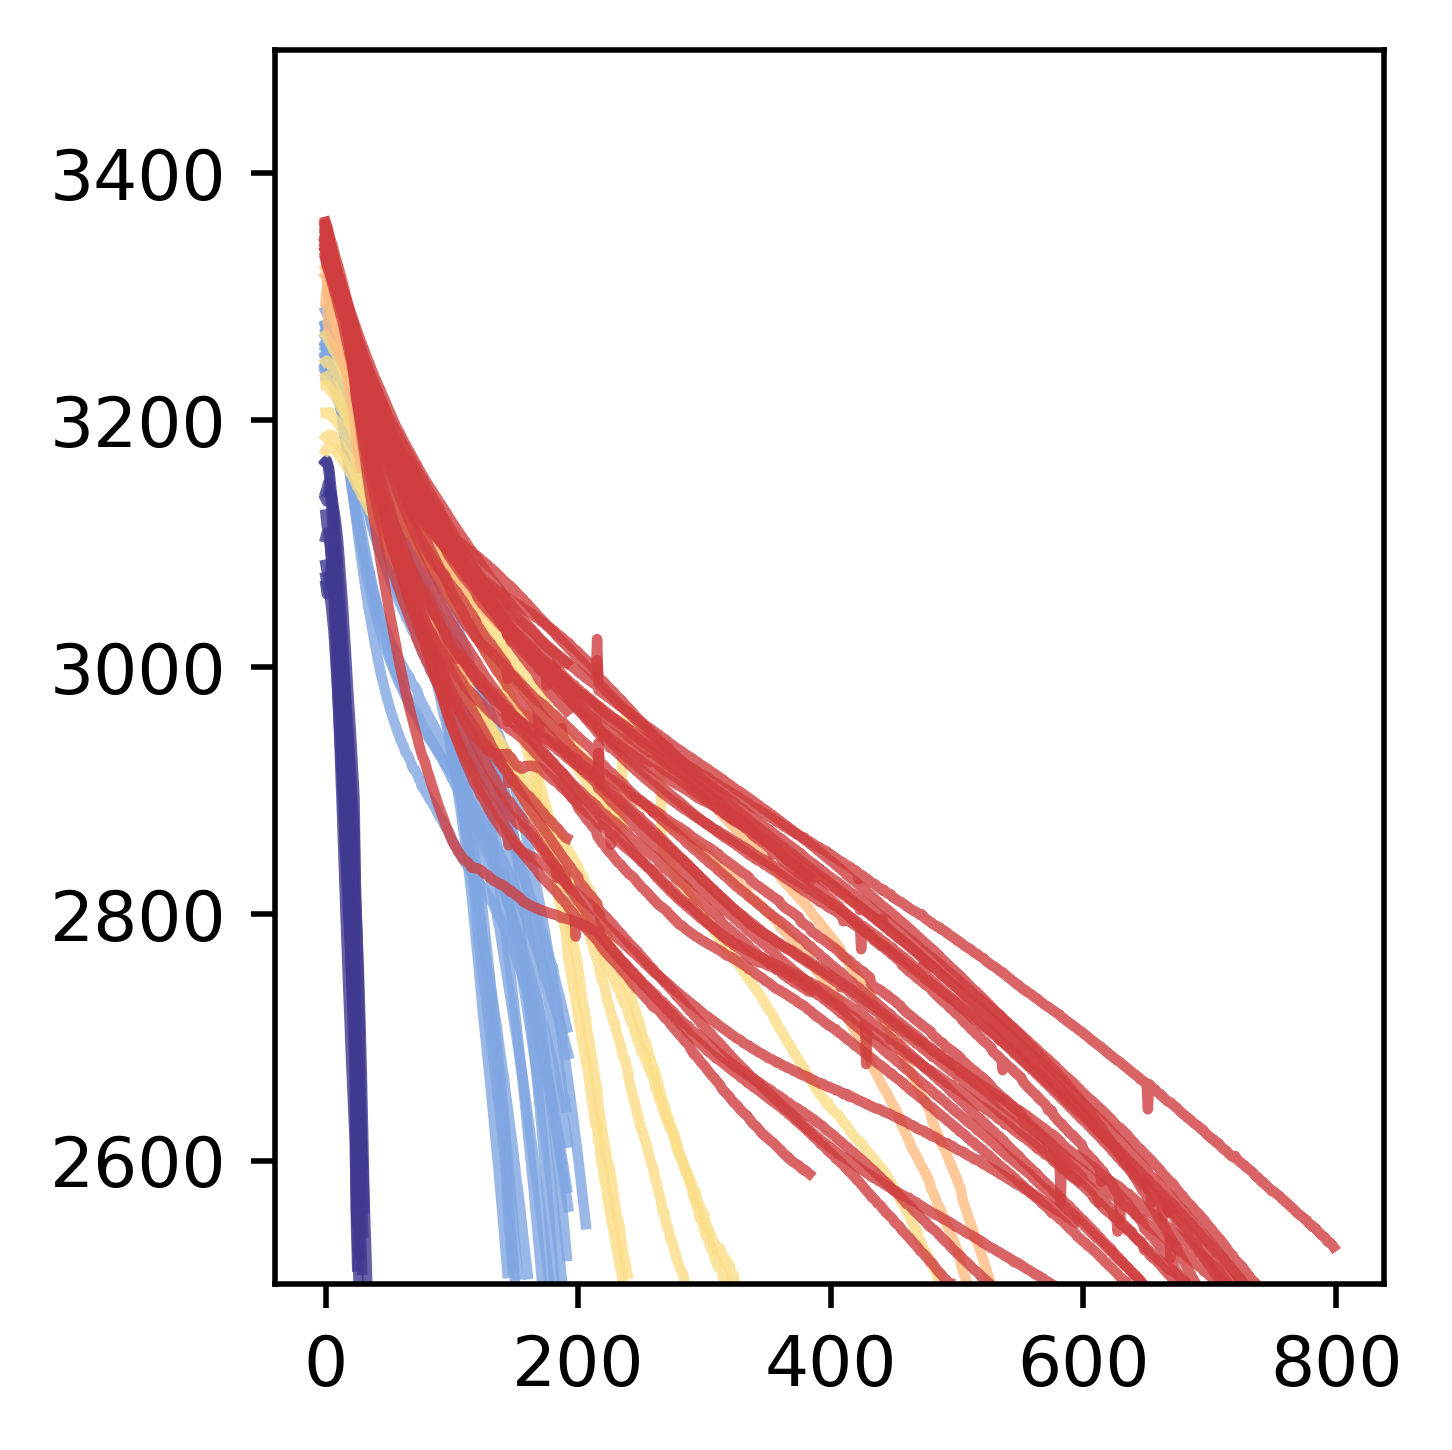

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

input_folder = 'dataset/UL-NCA/' 

file_types = {
    'CY25-1_1': ('CY25-1_1-#1.csv', 'CY25-1_1-#9.csv'), 
    'CY25-05_1': ('CY25-05_1-#1.csv', 'CY25-05_1-#19.csv'), 
    'CY25-025_1': ('CY25-025_1-#1.csv', 'CY25-025_1-#7.csv'), 
    'CY35-05_1': ('CY35-05_1-#1.csv', 'CY35-05_1-#3.csv'),  
    'CY45-05_1': ('CY45-05_1-#1.csv', 'CY45-05_1-#28.csv')  
}

colors = ["#403990", "#80A6E2", "#FBDD85", "#FFBC80", "#CF3D3E"]  

plt.figure(figsize=(3, 3), dpi=500)  

for file_idx, (file_type, (start_file, end_file)) in enumerate(file_types.items()):
    start_num = int(start_file.split('#')[1].split('.')[0])
    end_num = int(end_file.split('#')[1].split('.')[0])

    for file_num in range(start_num, end_num + 1):
        file_name = f'{file_type}-#{file_num}.csv'
        file_path = os.path.join(input_folder, file_name)

        if not os.path.exists(file_path):
            print(f"File {file_name} not found. Skipping...")
            continue

        data = pd.read_csv(file_path)

        cycle_numbers = np.arange(len(data))  
        discharge_capacity = data['Discharge_Capacity'].values 

        plt.plot(cycle_numbers, discharge_capacity, 
                color=colors[file_idx], 
                linewidth=1.5,
                alpha=0.8)  

plt.ylim(2500, 3500)

plt.title('') 
plt.xlabel('')
plt.ylabel('')
plt.grid(False) 
plt.tight_layout()
plt.show()

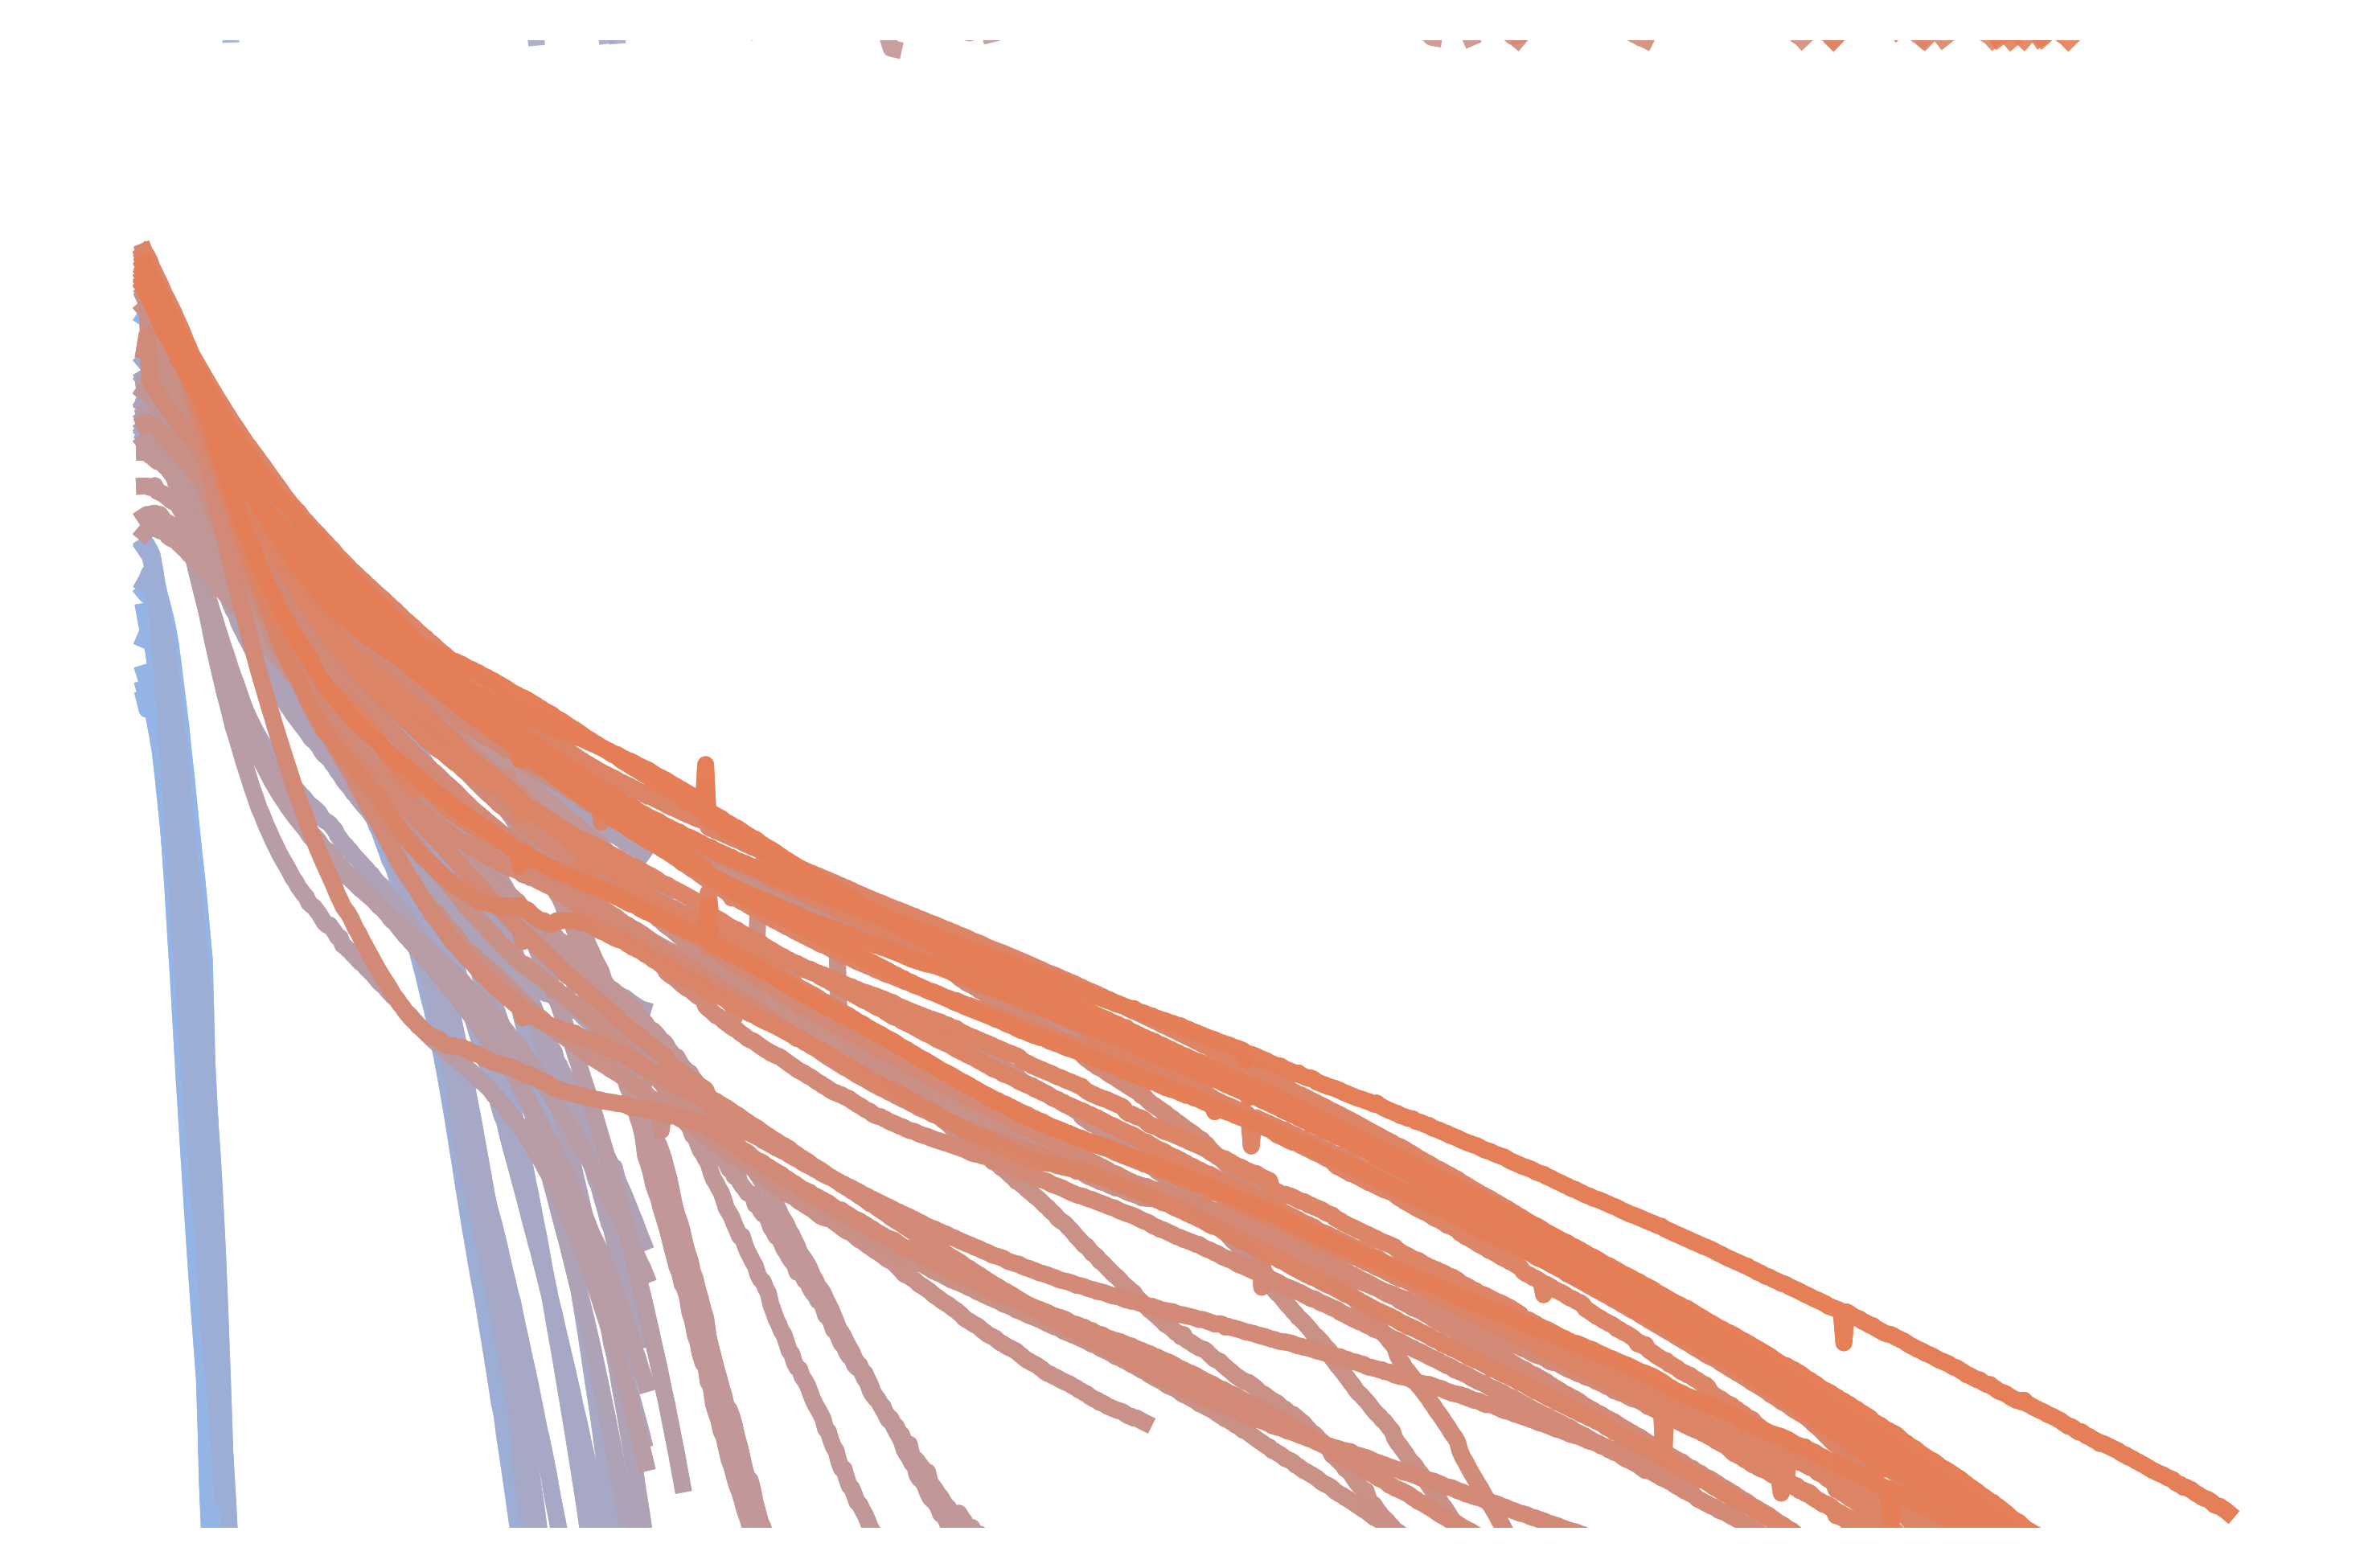

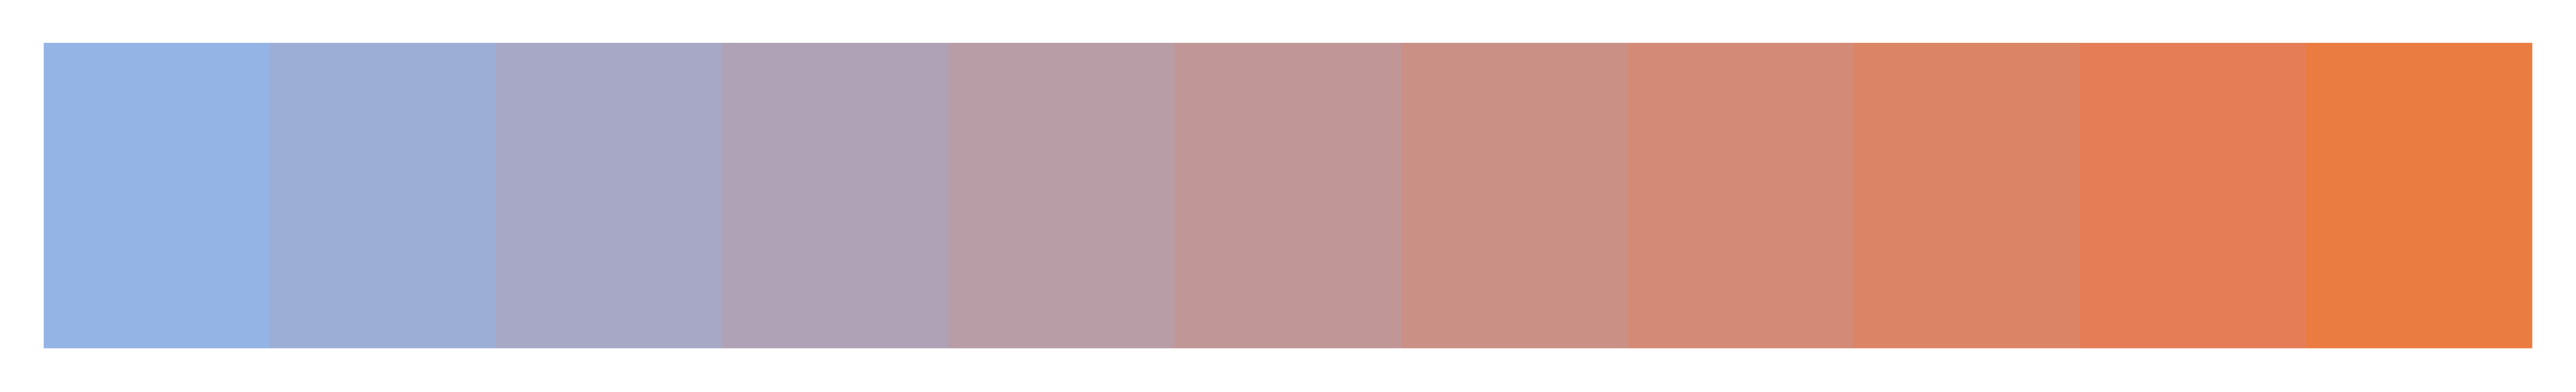

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

colors = ['#94b4e6', '#9daed6', '#a6a8c6', '#afa2b6', '#b89ca6', 
          '#c19696', '#ca9086', '#d38a76', '#dc8466', '#e57e56', 
          '#ea7b41']
datasets = [
    {
        "name": "NCA",
        "input_folder": 'dataset/UL-NCA/' ,
        "file_types": {
            'CY25-1_1': ('CY25-1_1-#1.csv', 'CY25-1_1-#9.csv'),
            'CY25-05_1': ('CY25-05_1-#1.csv', 'CY25-05_1-#19.csv'),
            'CY25-025_1': ('CY25-025_1-#1.csv', 'CY25-025_1-#7.csv'),
            'CY35-05_1': ('CY35-05_1-#1.csv', 'CY35-05_1-#3.csv'),
            'CY45-05_1': ('CY45-05_1-#1.csv', 'CY45-05_1-#28.csv')
        },
        "divisor": 3500 
    },
    {
        "name": "NCM",
        "input_folder": 'dataset/UL-NCM/',
        "file_types": {
            'CY25-05_1': ('CY25-05_1-#1.csv', 'CY25-05_1-#23.csv'),
            'CY35-05_1': ('CY35-05_1-#1.csv', 'CY35-05_1-#4.csv'),
            'CY45-05_1': ('CY45-05_1-#1.csv', 'CY45-05_1-#28.csv')
        },
        "divisor": 3500  
    },
    {
        "name": "NCM_NCA",
        "input_folder": 'dataset/UL-NCMNCA/',
        "file_types": {
            'CY25-05_1': ('CY25-05_1-#1.csv', 'CY25-05_1-#3.csv'),
            'CY25-05_2': ('CY25-05_2-#1.csv', 'CY25-05_2-#3.csv'),
            'CY25-05_4': ('CY25-05_4-#1.csv', 'CY25-05_4-#3.csv')
        },
        "divisor": 2500  
    }
]

all_batteries = []

for dataset in datasets:
    for file_idx, (file_type, (start_file, end_file)) in enumerate(file_types.items()):
        start_num = int(start_file.split('#')[1].split('.')[0])
        end_num = int(end_file.split('#')[1].split('.')[0])

        for file_num in range(start_num, end_num + 1):
            file_name = f'{file_type}-#{file_num}.csv'
            file_path = os.path.join(input_folder, file_name)

            if not os.path.exists(file_path):
                print(f"File {file_name} not found. Skipping...")
                continue
                
            data = pd.read_csv(file_path)
            cycle_numbers = np.arange(len(data))
            discharge_capacity = data['Discharge_Capacity'].values / dataset["divisor"]
            all_batteries.append({
                'cycles': cycle_numbers,
                'capacity': discharge_capacity,
                'length': len(data),
                'dataset': dataset["name"],
                'file_name': file_name,
                'divisor': dataset["divisor"] 
            })

all_batteries.sort(key=lambda x: x['length'])
fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
for i, battery in enumerate(all_batteries):
    color_idx = int((i / len(all_batteries)) * (len(colors) - 1))
    ax.plot(battery['cycles'], battery['capacity'], 
            color=colors[color_idx],
            linewidth=3,
            alpha=0.9)

ax.set_ylim(0.72, 1.0)


ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

fig_cbar, ax_cbar = plt.subplots(figsize=(6, 1),dpi=500)
fig_cbar.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=0, vmax=len(all_batteries)-1)

cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, norm=norm,
                             orientation='horizontal')
cb.set_ticks([]) 
cb.outline.set_visible(False)  

plt.tight_layout()
plt.show()